![Banner](./img/AI_Special_Program_Banner.jpg)

# Exercises on text classification with Naive Bayes
---

<h2 style="color:blue">Task 1 - Theory</h2>

Read [Sebastian Raschka's article](http://sebastianraschka.com/Articles/2014_naive_bayes_1.html) about the Naive Bayes method and answer the following questions:
1. Why is *additional smoothing* helpful? What is this method called in our theory section?
2. What is meant by the term *stop word*?
3. Why is the *Multi-variate Bernoulli Naive Bayes Method* suitable for spam detection?

<h3 style="color:blue">1.1 - Why is <em>additional smoothing</em> helpful?</h3>

Characteristics of our features that do not occur in the training dataset result in the **class-conditional probability** for this being 0. As a result, the a-posteriori probability for this will also always be 0. To avoid this problem, an additional parameter $\alpha$ is added to the Bayesian model. This is often called *Lidstone* smoothing or *Laplace* smoothing.

<h3 style="color:blue">1.2 - What is meant by the term <em>Stop Word</em>?</h3>

A "stop word" is a word that does not provide any information gain for the recognition/classification of text (they thus contradict the criteria of **salience** and **discrimination**).

Typically, these are articles, conjunctions, etc. Options for filtering out these words before modeling are to compare them against a "stop-word" dictionary of the language(s) under consideration. It is also possible to create an ordered list of the frequencies of the words used from the test data. This can then be used to manually create a list of stop words and remove them from the test data.

<h3 style="color:blue">1.3 - Why is the <em>Multi-variate Bernoulli Naive Bayes Method</em> suitable for spam detection?</h3>

For a general text classification, the multi-variate Bernoulli Naive Bayes method is theoretically inferior to the multinomial model, as the frequency of a feature is not taken into account here, but only whether it occurs at all or not. However, the selection of the vocabulary (removal of stop words etc.) is decisive for the quality of a model for spam detection. Good *data preparation* is therefore crucial here!

<h2 style="color:blue">Task 2 - Fake news classification</h2>

<h3 style="color:blue">Task 2.1: Model creation</h3>

Perform a classification with the fake news data set `../data/fake_news` from [Kaggle](https://www.kaggle.com/c/fake-news/data). The aim is to generate a model that can be used to classify a news article as *reliable* or *unreliable*.

If you have access to Packt Publishing, you can find more information on the task and NLP methods in general in [Chapter 8](https://subscription.packtpub.com/book/data/9781789955750/8) of the book [Python Machine Learning](https://github.com/rasbt/python-machine-learning-book) by [Sebastian Raschka](https://sebastianraschka.com/blog/index.html). Although no Naive Bayes model is used there, the steps of data understanding and data preparation are very similar. However, the task is very closely oriented to the lecture content and can therefore be mastered very well even without access to Raschka's book.

#### Hints
* Read the data correctly as *pandas Dataframe* and set the index correctly.
* Think about which type of vectorization and which type of model could be suitable for the task.
* Divide the data into training and test data, analogous to the lecture material.
* Check the balance of the data. How many items are reliable, how many are unreliable? Can you ensure that this balance is the same in the training and test data?
* Always evaluate the result taking into account the null-accuracy. This is the accuracy achieved by a model that stubbornly assumes the most frequent feature. Is your model better or worse than null-accuracy?
* Evaluate your model using a confusion matrix.

#### Attributes of the data set:

* id: unique id for a news article
* title: the title of a news article
* author: author of the news article
* text: the text of the article; could be incomplete
* label: a label that marks the article as potentially unreliable
    - 0: reliable
    - 1: unreliable

### Answer 2.1:

#### Import of libraries

In [1]:
import numpy as np
import pandas as pd
import sklearn.model_selection as ms
import sklearn.feature_extraction.text as text
import sklearn.naive_bayes as nb
import matplotlib.pyplot as plt

#### Importing the data

In [2]:
df = pd.read_csv('./data/fake_news.csv', index_col=0)
df.head()

,title,author,text,label
id,,,,
14649,See Real Voting System Rigged For Election The...,Activist Post,By Bev Harris A real-time demo of the most dev...,1
6473,Donald Trump Says He May Keep Parts of Obama H...,Reed Abelson,Just days after a national campaign in which h...,0
18736,Nunes ’Unmasking’ Report Vindicates Trump Clai...,Joel B. Pollak,House Intelligence Committee chair Rep. Devin ...,0
12347,Hillary’s Secret Is Out With What Camera Caugh...,Amanda Shea,Hillary’s Secret Is Out With What Camera Caugh...,1
17157,American Destroyer Fires Warning Shots at Iran...,Michael R. Gordon,WASHINGTON — In a vivid illustration of the...,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4406 entries, 14649 to 8416
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   4406 non-null   object
 1   author  4406 non-null   object
 2   text    4406 non-null   object
 3   label   4406 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 172.1+ KB


Balance of data:

In [4]:
df.groupby('label').count()

,title,author,text
label,,,
0,2533,2533,2533
1,1873,1873,1873


In [5]:
nok = df.groupby('label').count()['title'][0]
nnok = df.groupby('label').count()['title'][1]
percentage_nnok = round(nnok/(nok+nnok)*100, 2)
print(f'the relative frequency of unreliable articles is {percentage_nnok} percent.')

the relative frequency of unreliable articles is 42.51 percent.


#### Creation of the feature matrix and the label vector

The Tfidf vectorizer is used for this task. In contrast to spam-ham data sets, it is assumed that the word frequency could be a clue for recognizing fake news, as attention-grabbing words could occur repeatedly.

In [6]:
# Tfidf-vectoriser with the default settings is applied. 
tf = text.TfidfVectorizer()
X_vec = tf.fit(df['text'])
X = X_vec.transform(df['text'])
n_instances = X.shape[0]
n_words = X.shape[1]
print(f'Our {n_instances} Artikel contain {n_words} different words.')

Our 4406 Artikel contain 83026 different words.


In [7]:
print("The feature matrix has ~{0:.2f}% entries different from null.".format(
          100 * X.nnz / float(n_instances * n_words)))

The feature matrix has ~0.42% entries different from null.


In [8]:
# creation of label vector
y = df['label']

#### Division of the data

In [9]:
# Splitting the data into training and test data
(X_train, X_test, y_train, y_test) = ms.train_test_split(
    X, y, test_size=.2, random_state = 17, stratify=y)

##### Simple verification of stratification
First for the training data ...

In [10]:
print('There are {} training data, of which {} are unreliable(~ {}%)'.format(
    y_train.count(), y_train.sum(), round(y_train.sum()/y_train.count()*100,2)))

There are 3524 training data, of which 1498 are unreliable(~ 42.51%)


... and also for the test data to be on the safe side

In [11]:
print('There are {} training data, of which {} are unreliable(~ {}%)'.format(
    y_test.count(), y_test.sum(), round(y_test.sum()/y_test.count()*100,2)))

There are 882 training data, of which 375 are unreliable(~ 42.52%)


The distribution is therefore the same in training and test data - as desired!

#### Model training

The multinomial NB model is used to complement the Tfidf vectorizer:

In [12]:
# Bernoulli training
bnb = ms.GridSearchCV(nb.MultinomialNB(), param_grid={'alpha':np.logspace(-2., 2., 50)}, cv=5)
bnb.fit(X_train, y_train)
bnb.score(X_test, y_test)

0.8945578231292517

This result seems to be quite good. More details in the evaluation:

#### Evaluation

##### Null-Accuracy

In [13]:
nmb = y.count()
nmbunrel = np.count_nonzero(y)
nmbrel = nmb - nmbunrel
if nmbunrel >= nmbrel:
    print('Null-accuracy is the relationship between unreliable news and all news')
    nacc = 100*nmbunrel/nmb
    print("The Null-Accuracy is ~{0:.2f}% .".format(nacc))
else:
    print('Null-accuracy is the relationship between reliable news and all news')
    nacc = 100*nmbrel/nmb
    print("The Null-Accuracy is ~{0:.2f}% .".format(nacc))

Null-accuracy is the relationship between reliable news and all news
The Null-Accuracy is ~57.49% .


**Note**: This must be the case, because we had already seen above that 42.51% of the news were unreliable. Therefore, there are more reliable articles (namely the 57.49%) and since it is a binary problem, this of course represents the null-accuracy.

##### Confusion Matrix

In [14]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, bnb.predict(X_test))

array([[498,   9],
       [ 84, 291]])

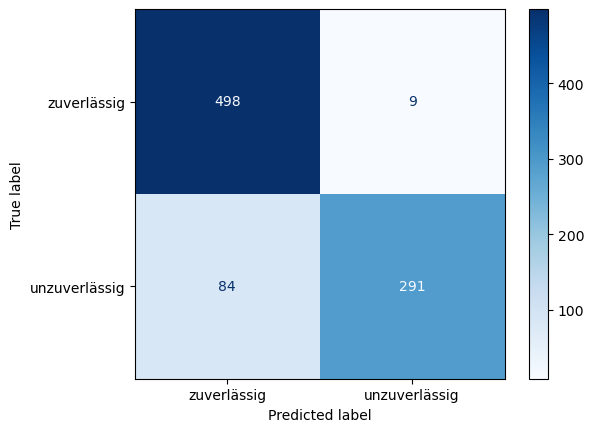

In [15]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(bnb, X_test, y_test, cmap='Blues', display_labels = ['zuverlässig', 'unzuverlässig'])
plt.show()

The model seems to do a valid job. We obtain an Accuracy that is 32% points above the null-accuracy. The confusion matrix shows an unbalanced classification of false-positive and false-negative cases, which is to be expected in an imbalanced dataset. All in all, however, the model appears to be useful.

<h3 style="color:blue">Task 2.2: Gain insights into the model</h3>

Do you trust your model? Find a way to display the words that influence the model the most in the classification.
#### Hints:
* At this point at the latest, you should think about the treatment of stop words.
* The conditional probabilities of the Naive Bayes model (*coefficients*) provide a good indication of the influence of words. Take a closer look at the attribute `feature_log_prob_` in the scikit-learn [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB).
* The `get_feature_names()` method of the Tfidf object is also helpful. This can be used to retrieve the vectorized words in plain text.
* Interpret your results!

### Answer 2.2:

The most influential words can be identified by the coefficients of the NB model. These represent the conditional probabilities $P(x_i|y)$ with $y \in \{0,1\}$, i.e. the probability that a word $x_i$ occurs, given class $y$. These coefficients can be found in the attribute `feature_log_prob_` of the model in logarithmic form.

#### Model training

To access the coefficients, the model is redefined:

In [16]:
nb_cl = nb.MultinomialNB(alpha=bnb.best_params_['alpha'])
nb_cl.fit(X_train, y_train)

MultinomialNB(alpha=0.012067926406393288)

In [17]:
nb_cl.score(X_test, y_test)

0.8945578231292517

#### Influential words

In [18]:
rel_class_prob_sorted = nb_cl.feature_log_prob_[0, :].argsort()
unrel_class_prob_sorted = nb_cl.feature_log_prob_[1, :].argsort()

word_list_rel = np.take(X_vec.get_feature_names_out(), rel_class_prob_sorted[:-15:-1])
word_list_unrel = np.take(X_vec.get_feature_names_out(), unrel_class_prob_sorted[:-15:-1])

print(f'Words with reliable association: \n {word_list_rel}')
print(f'Words with un reliable association:: \n {word_list_unrel}')

Words with reliable association: 
 ['the' 'to' 'of' 'and' 'in' 'that' 'mr' 'on' 'said' 'he' 'for' 'is' 'it'
 'was']
Words with un reliable association:: 
 ['the' 'to' 'of' 'and' 'in' 'that' 'is' 'for' 'it' 'on' 'clinton' 'as'
 'are' 'this']


Both lists contain predominantly stop words. This is not surprising, as the `feature_log_prob_` contain the (logarithmized) conditional probabilities of the words and these are highest for frequently occurring words.

It would therefore be expected that the result can be improved by removing the stopwords.

#### Test without Stop Words

Remove the Stop Words with TfidfVectorizer:

In [19]:
# Tfidf-vectoriser with the default settings is applied. 
tf = text.TfidfVectorizer(stop_words='english')
X_vec = tf.fit(df['text'])
X = X_vec.transform(df['text'])
n_instances = X.shape[0]
n_words_without_stop = X.shape[1]
print(f'Our {n_instances} articles contain {n_words_without_stop}\
 different words ( {n_words - n_words_without_stop} stop words where deleted).')

Our 4406 articles contain 82720 different words ( 306 stop words where deleted).


In [20]:
print("The feature matrix has ~{0:.2f}% not null entries.".format(
          100 * X.nnz / float(n_instances * n_words_without_stop)))

The feature matrix has ~0.33% not null entries.


In [21]:
# Create label vector
y = df['label']

#### Division of the data

In [22]:
# Splitting the data into training and test data
(X_train, X_test, y_train, y_test) = ms.train_test_split(
    X, y, test_size=.2, random_state = 17, stratify=y)

In [23]:
nb_cl = nb.MultinomialNB(alpha=bnb.best_params_['alpha'])
nb_cl.fit(X_train, y_train)

MultinomialNB(alpha=0.012067926406393288)

In [24]:
nb_cl.score(X_test, y_test)

0.8922902494331065

Interestingly, the accuracy is even slightly lower after removing the stop words. One possible assumption could be that stop words are found particularly frequently in "simple texts" and that there is a suspicion that fake news is aimed precisely at people who are easier to influence and could therefore use simpler language. This would have to be investigated more closely ...

#### Influential words

In [25]:
rel_class_prob_sorted = nb_cl.feature_log_prob_[0, :].argsort()
unrel_class_prob_sorted = nb_cl.feature_log_prob_[1, :].argsort()

word_list_rel = np.take(X_vec.get_feature_names_out(), rel_class_prob_sorted[:-20:-1])
word_list_unrel = np.take(X_vec.get_feature_names_out(), unrel_class_prob_sorted[:-20:-1])

print(f'words, with reliable association: \n {word_list_rel}')
print(f'words, with unreliable association: \n {word_list_unrel}')

words, with reliable association: 
 ['mr' 'said' 'trump' 'president' 'people' 'ms' 'new' 'like' 'state'
 'states' 'united' 'house' 'news' 'twitter' 'obama' 'just' 'clinton'
 'time' 'breitbart']
words, with unreliable association: 
 ['clinton' 'trump' 'hillary' 'people' 'election' '2016' 'fbi' 'world'
 'campaign' 'russia' 'obama' 'media' 'new' 'said' 'government' 'just'
 'state' 'like' 'war']


These words make more sense. Nevertheless, it is noticeable that the same words often occur in both lists. We will therefore now examine which words do not overlap:

In [26]:
print(f'Words that only appear in the list of reliable words \n \
 {[x for x in word_list_rel if x not in word_list_unrel]}')

Words that only appear in the list of reliable words 
  ['mr', 'president', 'ms', 'states', 'united', 'house', 'news', 'twitter', 'time', 'breitbart']


In [27]:
print(f'Words that only appear in the list of unreliable words: \n \
 {[x for x in word_list_unrel if x not in word_list_rel]}')

Words that only appear in the list of unreliable words: 
  ['hillary', 'election', '2016', 'fbi', 'world', 'campaign', 'russia', 'media', 'government', 'war']


It should be noted that words in both categories are exclusively associated with politics. The data set obviously originates from the 2016 presidential elections in the USA. However, the assignment of the word [breitbart](https://en.wikipedia.org/wiki/Breitbart_News) to the reliable articles casts doubt on the quality of the data set, although it is of course possible that reliable sources write articles about Breitbart's unreliability ... That would certainly need to be investigated more closely.

<h3 style="color:blue"><b>Bonus task 2.3</b>: Authors instead of texts?</h3>

Perhaps fake news can be identified by the author alone? Create a model that uses the *authors as features* instead of the texts.
#### Hints:
* Why does this work particularly well/badly? Tip: Pay attention to the distribution of authors. Support your assumption with suitable data or visualizations!
* How useful do you think a model that only uses authors for classification is?

### Answer 2.3:

Vectorization of the authors:

In [28]:
# Tfidf-Vektorisierer mit den default-Einstellungen wird angewendet. 
tf = text.TfidfVectorizer()
X_vec = tf.fit(df['author'])
X = X_vec.transform(df['author'])
n_instances = X.shape[0]
n_authors = X.shape[1]
print(f'Our {n_instances} articles are from {n_authors} different authors.')

Our 4406 articles are from 2180 different authors.


In [29]:
print("The feature matrix has ~{0:.2f}% not null entries.".format(
          100 * X.nnz / float(n_instances * n_authors)))

The feature matrix has ~0.11% not null entries.


In [30]:
# create the lable vector
y = df['label']

#### Division of the data

In [31]:
# Splitting in training and test data
(X_train, X_test, y_train, y_test) = ms.train_test_split(
    X, y, test_size=.2, random_state = 17, stratify=y)

#### Model training

In [32]:
# Bernoulli training
bnb = ms.GridSearchCV(nb.MultinomialNB(), param_grid={'alpha':np.logspace(-2., 2., 50)}, cv=5)
bnb.fit(X_train, y_train)
bnb.score(X_test, y_test)

0.9399092970521542

Compared to the previous tests, this accuarcy is even greater. So perhaps certain authors appear more frequently and can be clearly associated with the publication of reliable or unreliable articles? This now needs to be checked!

#### Influential words

In [33]:
nb_cl = nb.MultinomialNB(alpha=bnb.best_params_['alpha'])
nb_cl.fit(X_train, y_train)

MultinomialNB(alpha=0.01)

In [34]:
nb_cl.score(X_test, y_test)

0.9399092970521542

In [35]:
rel_class_prob_sorted = nb_cl.feature_log_prob_[0, :].argsort()
unrel_class_prob_sorted = nb_cl.feature_log_prob_[1, :].argsort()

word_list_rel = np.take(X_vec.get_feature_names_out(), rel_class_prob_sorted[:-20:-1])
word_list_unrel = np.take(X_vec.get_feature_names_out(), unrel_class_prob_sorted[:-20:-1])

print(f'Authors, with reliable assiciation: \n {word_list_rel}')
print(f'Authors, with not reliable assiciation: \n {word_list_unrel}')

Authors, with reliable assiciation: 
 ['and' 'john' 'breitbart' 'michael' 'charlie' 'pam' 'key' 'ian' 'ben'
 'hudson' 'jerome' 'daniel' 'spiering' 'hayward' 'hanchett' 'joel'
 'pollak' 'baker' 'kew']
Authors, with not reliable assiciation: 
 ['admin' 'com' 'noreply' 'blogger' 'the' 'starkman' 'alex' 'author'
 'pakalert' 'ansary' 'lavine' 'eddy' 'gillian' 'editor' 'staff' 'post'
 'activist' 'wmw_admin' 'dyer']


Unlike the texts, there are no identical values in these lists. This indicates that the authors delimit the data more sharply. This is followed by some investigations into the distribution of authors. Perhaps only a few authors are responsible for the majority of the articles in the data set? This will first be investigated with a plot of the 30 *most active* authors:

<Axes: ylabel='author'>

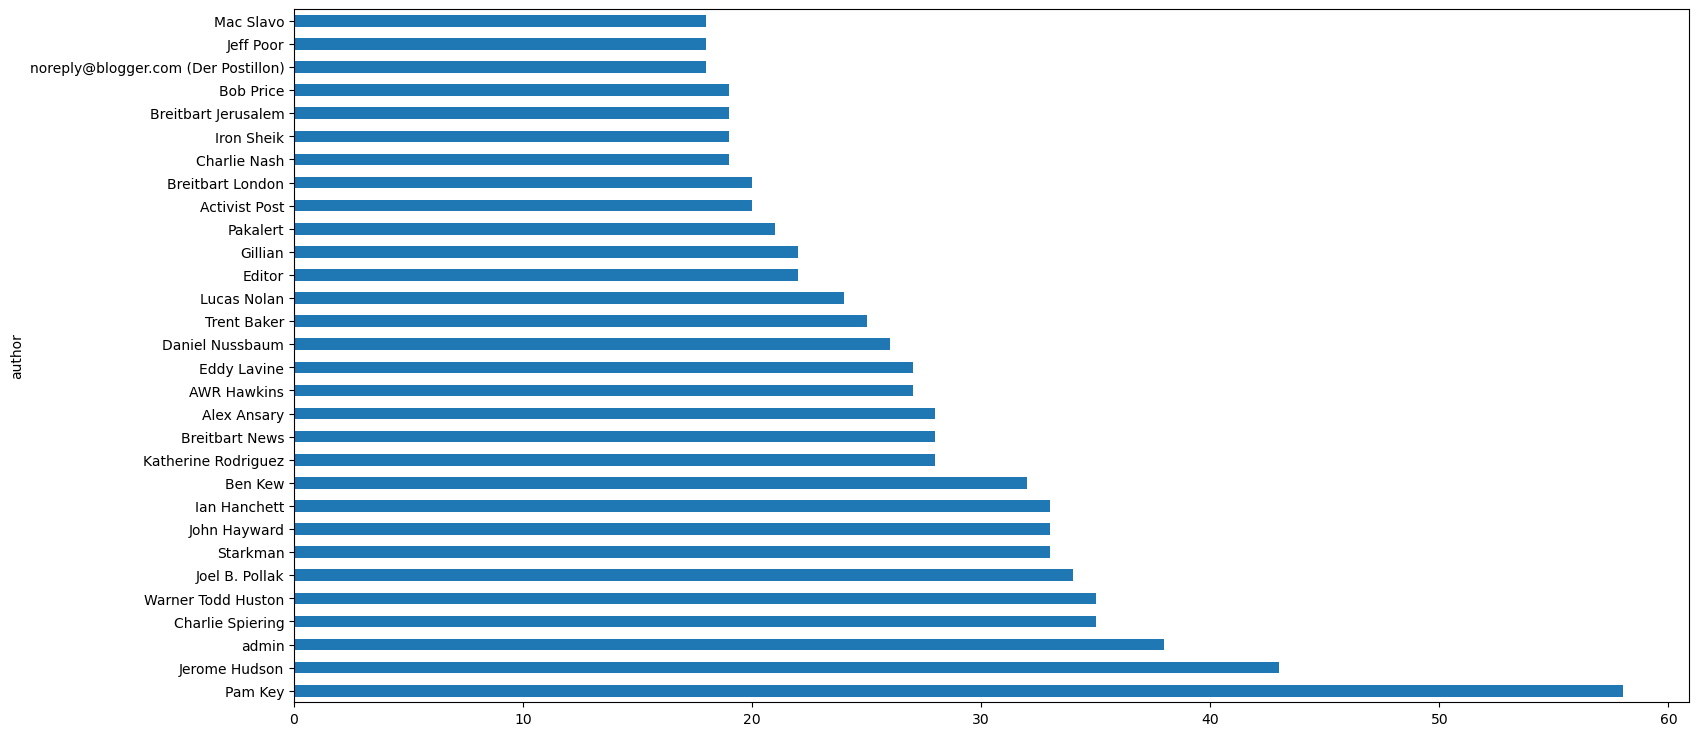

In [36]:
plt.figure(figsize=(18,9))
df['author'].value_counts()[:30].plot.barh()

As you can see, the 30 most active authors have a large number of publications. The distribution for all authors can be shown in more detail:

In [37]:
df_authors = pd.DataFrame(data = df['author'].value_counts()).reset_index()
df_authors['prct_of_total'] = df_authors['count']/len(df)

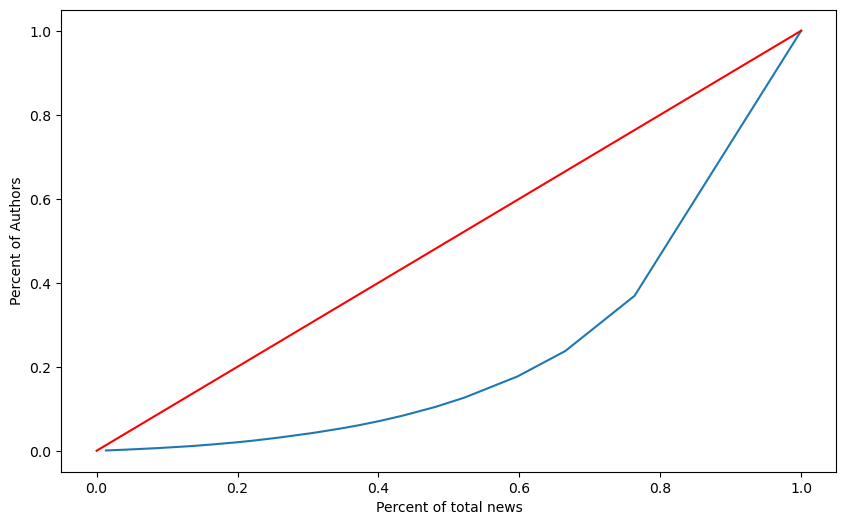

In [38]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(np.cumsum(df_authors['prct_of_total']), np.cumsum([1/len(df_authors) for x in range(len(df_authors))]))
plt.xlabel('Percent of total news')
plt.ylabel('Percent of Authors')
## line plot of equality
ax.plot([0,1], [0,1], color='r')

As you can see, around 20% of authors already write over 60% of the articles. [Pareto](https://en.wikipedia.org/wiki/Pareto_principle) would probably be proud of the data. For comparison: the diagonal represents a perfectly equal distribution. This type of cumulative percentage representation is also known as the [Lorenz curve](https://en.wikipedia.org/wiki/Lorenz_curve).

The distribution of authors shown provides a conclusive starting point for why the Naive Bayes model is able to classify this data set based solely on the authors. It could well be that the individual authors publish predominantly unreliable or reliable articles - but not both equally. This assumption is visualized for the 30 most active authors:

In [39]:
df_authors['unrel_articles'] = df.groupby(['author']).sum()['label'].loc[df_authors['author']].values

In [40]:
df_authors['rel_articles'] = df_authors['count'] - df_authors['unrel_articles']

<Axes: xlabel='author'>

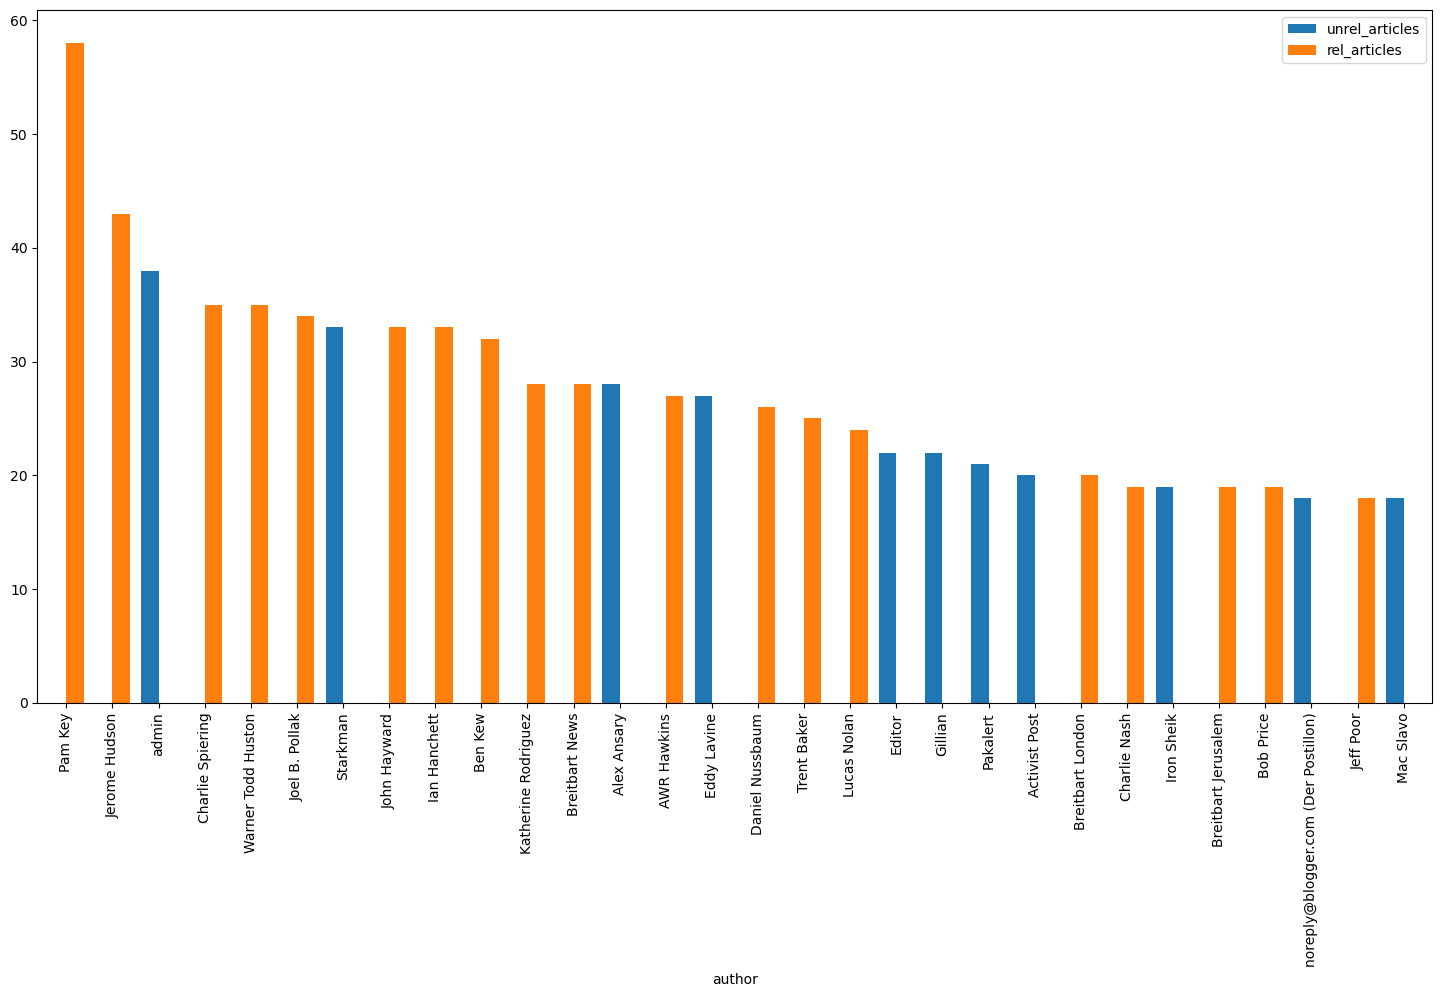

In [41]:
df_authors[['author', 'unrel_articles', 'rel_articles']][:30].plot.bar(x='author', figsize=(18,9), width=0.75)

This assumption is confirmed, at least for the 30 most active authors. All of these authors can be clearly assigned to a category. This is what makes classification with Naive Bayes so efficient. But ***caution*** - such a model is of course unsuitable for an unknown data set, as other authors then occur...

But: you could of course first check whether an article comes from one of the known authors (perhaps even only for those for which the assignment is clear and for which a sufficient number of articles is available). Only if this is not the case do you look at the text itself.